In [1]:
import laminoAlign as lam
from laminoAlign.plotting import plotImage

import matplotlib.pyplot as plt
import cupy as cp
import numpy as np
import warnings
import os

warnings.filterwarnings("ignore", category=np.ComplexWarning)
plt.rcParams['image.cmap'] = 'bone'

# Select which GPU to use
cp.cuda.Device(0).use()

In [ ]:
# Specify saveFolder (where data will be saved to)
saveFolder = '/some/file/path/'
# Specify location of config file
configFileName = 'config_TP2.ini'
configPath = os.path.join(os.getcwd(), configFileName)
# Create saveFolder if it doesn't exist
if not os.path.isdir(saveFolder):
    os.makedirs(saveFolder)

In [5]:
# Read in the configuration file
config = lam.read.getConfig(configPath)
# Create the object that handles finding filepaths and loading data
fileReader = lam.read.fileReader_mat(config)
# Load the data
data = lam.data.data(
    config,
    fileReader)
data.configPath = configPath
# Indicate where data will be saved
lam.data.data.setFolders(data, parentFolder=saveFolder)

No projection data found for scan 1282
No projection data found for scan 1292
No projection data found for scan 1297
No projection data found for scan 1336
No projection data found for scan 1337
No projection data found for scan 1338
No projection data found for scan 1339
No projection data found for scan 1340
No projection data found for scan 1341
No projection data found for scan 1342
No projection data found for scan 1343
No projection data found for scan 1344
No projection data found for scan 1345
No projection data found for scan 1346
No projection data found for scan 1347
No projection data found for scan 1348
No projection data found for scan 1349
No projection data found for scan 1350
No projection data found for scan 1351
No projection data found for scan 1352
No projection data found for scan 1353
No projection data found for scan 1354
No projection data found for scan 1355
No projection data found for scan 1356
No projection data found for scan 1357
No projection data found 

Loading projections into list...
12.3928 s  Loading projections into list...Completed


Single Frame Size: (2420, 1494) 
Number of Frames: 199


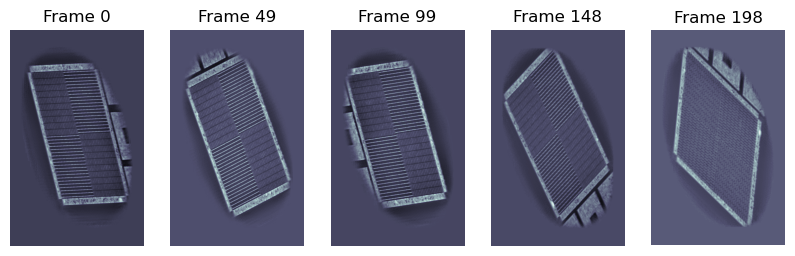

In [6]:
# Plot a few stackObject frames and some information
%matplotlib inline
lam.data.data.plotSamples(imageStack=data.stackObject,
                          imageFunc=np.angle)

Fixing stack dimensions...
3.2719 s  Fixing stack dimensions...Completed
Converting list to array...
2.0780 s  Converting list to array..Completed
Single Frame Size: (2368, 1472) 
Number of Frames: 199


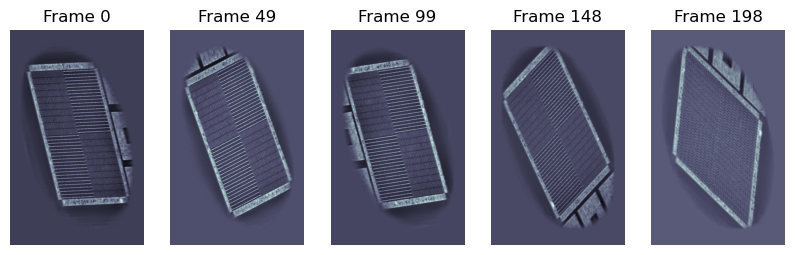

In [14]:
# - Crop/pad each of the projections so that they are the same size
# - Then convert from list to array
lam.data.data.equalizeStackSize(data)
# - Show some plots of the stackObject after cropping
data.plotSamples(data.stackObject, np.angle)

iteration 10/10
8.0299 s  Affine Transform Time
Single Frame Size: (1472, 2368) 
Number of Frames: 199


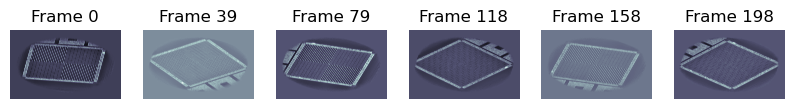

In [15]:
# Remove unwanted tilt and skew from the projections -- the tilt and skew are pulled from the
# values in the config file.
lam.data.data.removeTiltAndSkew(data)
# Check that the data looks reasonable
data.plotSamples(data.stackObject, np.angle, N=6)

iteration 1/1


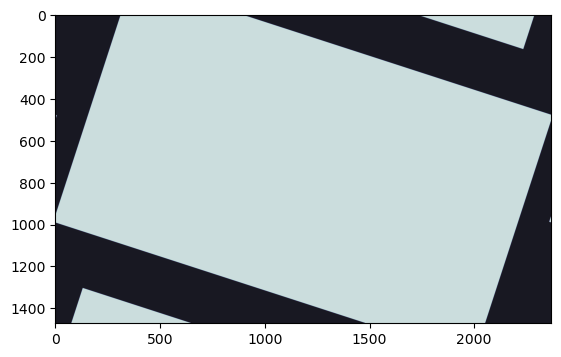

In [114]:
# Get the illumination at each point on the first
# Not extremely important, only used in cross-correlation alignment.
# If there is trouble with this function, you should be able to just replace
# data.illumSum with an array of 1s that is the size of the stackObject

lam.data.data.getIllumSum(data)
plotImage(data.illumSum)
plt.show()

In [116]:
data.setObjectROI()

Object ROI: 
 - Vertical: 0 to 1471 
 - Horizontal: 0 to 2367


Cross-correlation ROI: 
 - Vertical: 512 to 959 
 - Horizontal: 960 to 1407
Single Frame Size: (1472, 2368) 
Number of Frames: 199


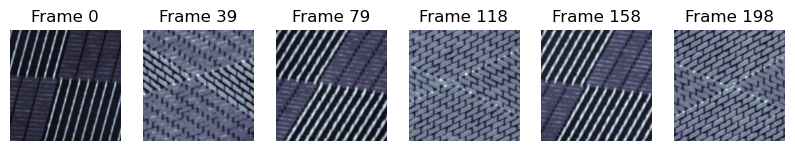

In [120]:
# Set the ROI for cross-correlation.
# The ROI should not contain edges of the sample.
%matplotlib inline
wL = 32*15
lam.data.data.setXCorrROI(data, widths=[wL, wL])
%matplotlib inline
lam.data.data.plotSamples(imageStack=data.stackObject,
                          imageFunc=np.angle,
                          N=6,
                          ROI=data.xCorrROI)

iteration 10/10
0.0198 s  Loop time


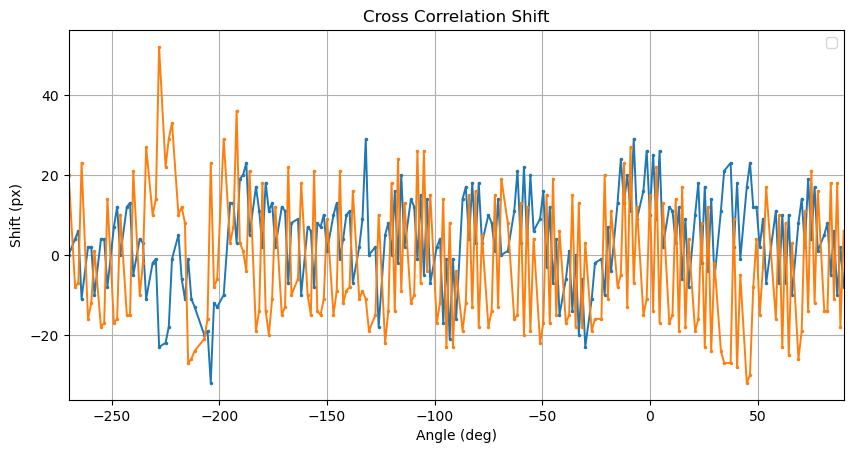

In [121]:
# Get the cross-correlation pre-alignment
%matplotlib inline
lam.data.data.crossCorrelationAlign(data)
lam.data.data.plotShift(data, [data.xCorrShift], 'Cross Correlation Shift')

In [122]:
# Apply the cross-correlation pre-alignment to the stackObject
lam.utils.imShiftLinear(data.stackObject, data.xCorrShift);

In [138]:
lam.data.data.estimateReliabilityRegion(data, method=1)

0.1746 s  Loop Time
iteration 199/199


Single Frame Size: (1472, 2368) 
Number of Frames: 199


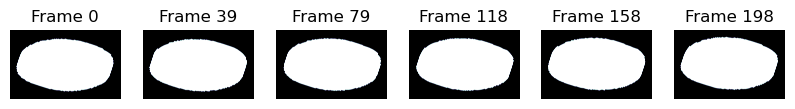

In [141]:
data.plotSamples(data.weightSino, N=6)

Single Frame Size: (1472, 2368) 
Number of Frames: 199


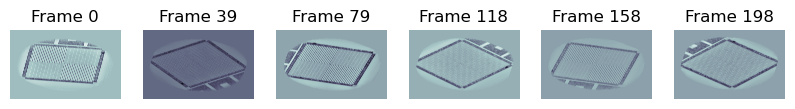

In [144]:
# Do 2D phase wrapping to get the sinogram
lam.data.data.unwrapPhase2D(data)
%matplotlib inline
lam.data.data.plotSamples(data.sinogram, N=6)

In [145]:
data.setAlignmentROI()
data.reconstructionPrep()

Alignment ROI: 
 - Vertical: 0 to 1471 
 - Horizontal: 0 to 2367
Number of pixels in full resolution 3D reconstruction: [2496 2496  256] px
Pixel Size: 27.5 nm
Reconstruction dimensions: [68.6, 68.6, 7.0] um


In [149]:
CoROffset = data.updatedGeometry['CoROffset']
print("Center of rotation (CoR) offset from config file:", CoROffset)

Center of rotation (CoR) offset from config file: [-47.89444444   0.        ]


Iteration 0: Max step size update: 0.8000 px

0.0724 s  Shift Sinogram and Weights
0.0277 s  FBP: Apply Filter
0.0126 s  Astra: Create Geometry and Objects
0.0001 s  Astra: Create Algorithm
0.0108 s  Astra: Run Algorithm
0.0010 s  Astra: Retrieve Reconstruction
0.0245 s  FBP: Astra Reconstruct
0.0069 s  Apply Circular Mask
0.1513 s  TOTAL LOOP TIME
0.3571 s  Projection Matching Execution Time


<Figure size 640x480 with 0 Axes>

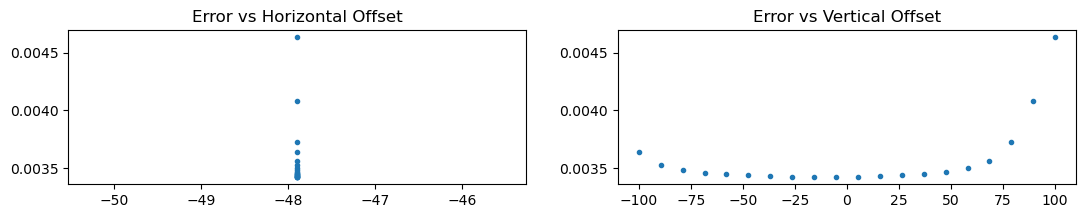

Estimated Center of Rotation (H,V): (-47.9, -15.8)


In [150]:
# Estimate vertical center of rotation
%matplotlib inline
updateConfig = {'Estimate CoR': {'offsetCoR_V_center': CoROffset[1],
                                 'offsetCoR_V_range': 200,
                                 'offsetCoR_V_iterations': 20,
                                 'offsetCoR_H_center': CoROffset[0],
                                 'offsetCoR_H_range': 0,
                                 'offsetCoR_H_iterations': 1}}
CoROffset = lam.data.data.estimateCoROffset(data, updateConfig)

Iteration 0: Max step size update: 0.4492 px

0.0724 s  Shift Sinogram and Weights
0.0277 s  FBP: Apply Filter
0.0122 s  Astra: Create Geometry and Objects
0.0001 s  Astra: Create Algorithm
0.0106 s  Astra: Run Algorithm
0.0009 s  Astra: Retrieve Reconstruction
0.0239 s  FBP: Astra Reconstruct
0.0061 s  Apply Circular Mask
0.1496 s  TOTAL LOOP TIME
0.3546 s  Projection Matching Execution Time


<Figure size 640x480 with 0 Axes>

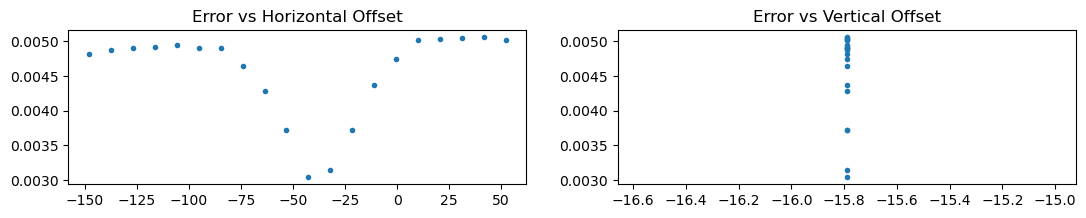

Estimated Center of Rotation (H,V): (-42.6, -15.8)


In [151]:
# Estimate horizontal center of rotation
%matplotlib inline
updateConfig = {'Estimate CoR': {'offsetCoR_V_center': CoROffset[1],
                                 'offsetCoR_V_range': 0,
                                 'offsetCoR_V_iterations': 1,
                                 'offsetCoR_H_center': CoROffset[0],
                                 'offsetCoR_H_range': 200,
                                 'offsetCoR_H_iterations': 20}}
# Change the parameters manually to zero in on the CoR that minimizes error
CoROffset = lam.data.data.estimateCoROffset(data, updateConfig)

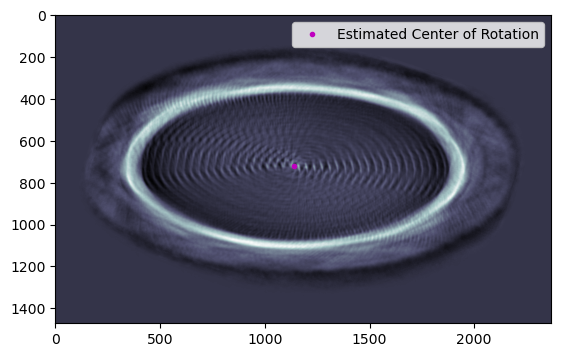

In [152]:
# Roughly check that the CoR is actually around the center
plotImage(data.sinogram.sum(axis=0))
CoR = np.array(data.sinogram.shape[1:])/2 + CoROffset[::-1]
plt.plot(CoR[1], CoR[0], '.m', label='Estimated Center of Rotation')
plt.legend()

In [153]:
# Update the center of rotation offset
data.updatedGeometry['CoROffset'] = np.array(CoROffset)
print("New CoR Offset:", CoROffset)

New CoR Offset: (-42.631286549707596, -15.78947368421052)


In [ ]:
data.saveAll("TP2_exampleScript_beforePMA")

In [ ]:
# # Reload data if necessary
# loadFolder = os.path.join(saveFolder, "data objects", "TP2_exampleScript_beforePMA")
# data = lam.data.data(reload=True,
#                     loadFolder=loadFolder,
#                     loadStackObject=True)

In [ ]:
%matplotlib inline
# Override settings from config file
updateConfig = {'Projection Matching': {'binningArray': [32, 16, 8, 4, 2],
                                        'maxIter': 300,
                                        'minStepSize': 0.01}}
# WhichPlots determines what kinds of movies will be saved
whichPlots = {'incremental shifts 0': False,
              'incremental shifts 1': False,
              'cumulative shifts 0': True,
              'cumulative shifts 1': True,
              'reconstruction': True,
              'aligned sinogram': True,
              'model sinogram': True,
              'initial sinogram': True,
              'weighted initial sinogram': False}
# Run the projection-matching alignment sequence
lam.data.data.runReconstructionSequence(
    data,
    folder=data.folders['alignment results'],
    updateConfig=updateConfig,
    saveData='all',
    whichPlots=whichPlots
)
%matplotlib inline

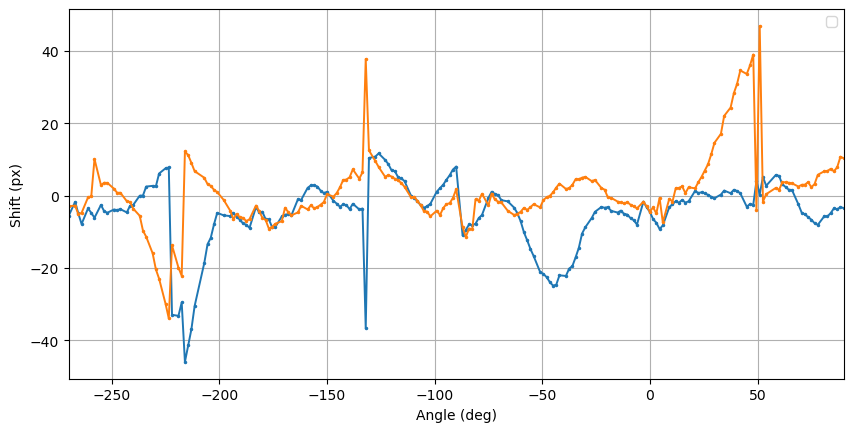

In [158]:
# Plot the alignment shift as of this point
%matplotlib inline
data.plotShift([data.projMatch.shiftTotal])
plt.show()

In [ ]:
data.saveAll("TP2_exampleScript_2xAligned")

In [ ]:
# # Reload data if necessary
# loadFolder = os.path.join(saveFolder, "data objects", "TP2_exampleScript_2xAligned")
# data = lam.data.data(reload=True,
#                     loadFolder=loadFolder,
#                     loadStackObject=True)

In [ ]:
# Run at high resolution
# Note that the stepRelaxation value must often be increased at the end of the alignment
%matplotlib inline
# Override settings from config file
updateConfig = {'Projection Matching': {'binningArray': [1],
                                        'maxIter': 300,
                                        'stepRelaxation': 0.5,  # Increased from initial value
                                        'minStepSize': 0.01}}
whichPlots = {'incremental shifts 0': False,
              'incremental shifts 1': False,
              'cumulative shifts 0': True,
              'cumulative shifts 1': True,
              'reconstruction': True,
              'aligned sinogram': True,
              'model sinogram': True,
              'initial sinogram': True,
              'weighted initial sinogram': False}
# Run the projection-matching alignment sequence
lam.data.data.runReconstructionSequence(
    data,
    folder=data.folders['alignment results'],
    updateConfig=updateConfig,
    saveData='all',
    whichPlots=whichPlots,
    shifts=data.projMatch.shiftTotal*1  # Initialize with the shift from the previous alignment
)
%matplotlib inline

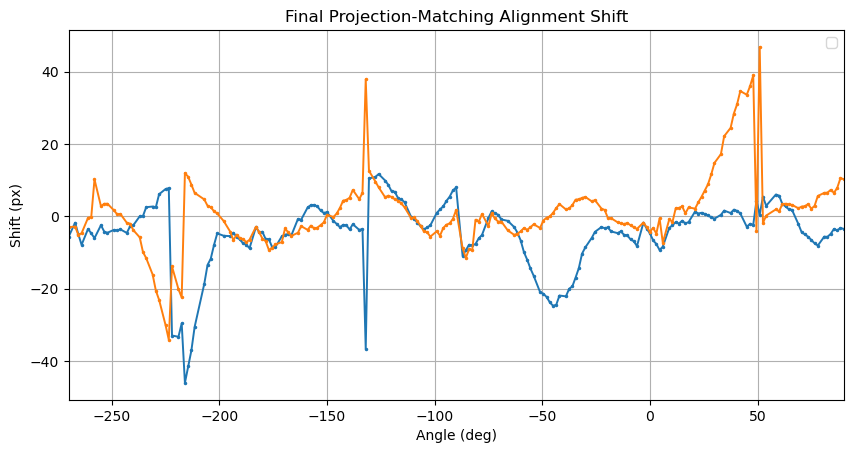

In [168]:
data.plotShift([data.projMatch.shiftTotal], title="Final Projection-Matching Alignment Shift")

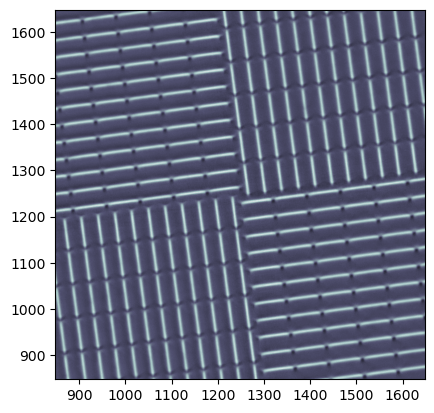

In [173]:
# Plot a slice of the final reconstruction
plotImage(data.projMatch.rec[128], 800)
plt.show()

In [ ]:
data.saveAll("TP2_cSAXS_completedPMA")

In [180]:
# Apply the PMA shift to the sinogram and weights
data.sinogram = lam.data.data.fftImShiftStack(data.sinogram, data.projMatch.shiftTotal)
data.weightSino = lam.data.data.fftImShiftStack(data.weightSino, data.projMatch.shiftTotal)

In [181]:
# Get the 3D reconstruction and store in data.tomogram
data.astraReconstruct();

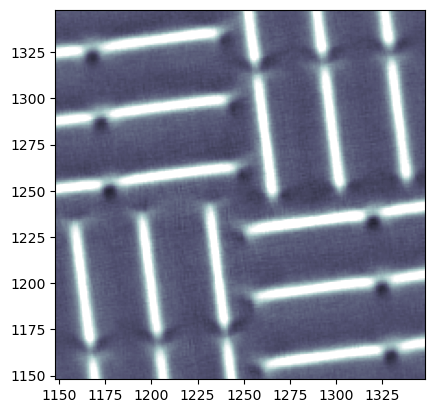

In [184]:
# Plot one slice of the reconstruction
plotImage(data.tomogram[128], 200)
plt.clim([-0.024, 0.024])
plt.show()

In [183]:
# Get angles to rotate the reconstruction by
data.getRotationAngles()
# Rotate the reconstruction
data.rotateTomogram()

Rotation angles stored in tomoRotAngles:  [-0.05609018  0.03409018  7.49487976]
tomogram rotated by [-0.05609018  0.03409018  7.49487976] 
Rotated tomogram is stored in tomogram_rot


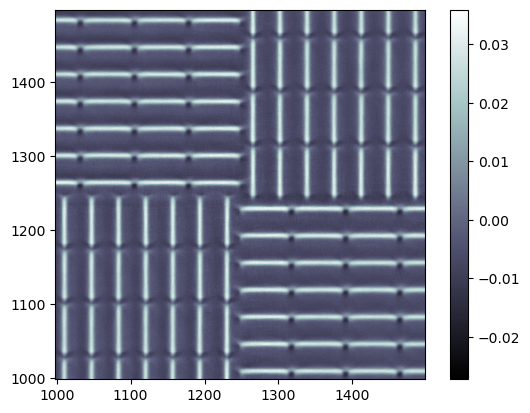

In [234]:
# Plot one slice of the reconstruction
plotImage(data.tomogram_rot[130], 500)
plt.colorbar()
plt.show()

In [ ]:
# Save the final result in a data object
data.saveAll("TP2_exampleScript_final")

In [ ]:
# Save as .tiff
lam.data.data.saveAsTIFF(data, data.tomogram_rot, 'TP2_final_reconstruction')

In [235]:
movieFolder = os.path.join(data.folders['parent'], "movies")
if not os.path.isdir(movieFolder):
    os.makedirs(movieFolder)

filename = os.path.join(movieFolder, "reconstruction_DPI200_FPS15")
FPS = 15
clim = [-0.012, 0.022]
lam.plotting.animateStack(
    data.tomogram_rot,
    title="",
    filename=filename,
    FPS=FPS,
    DPI=200,
    plotType='mp4',
    clim=clim)

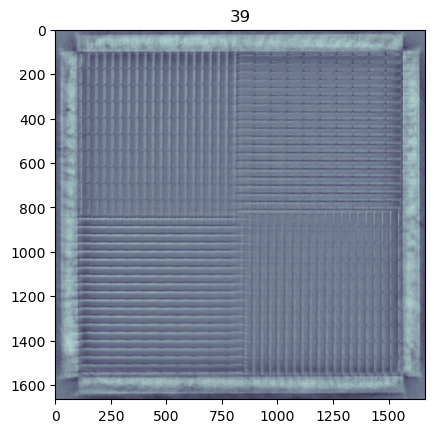

In [292]:
w = 1700
ROI = data.setGeneralROI(data.tomogram_rot.shape[1:], [w, w])
data.notebookAnimate(data.tomogram_rot[110:150][:, ROI[0]][:, :, ROI[1]], vlim=[-0.015, 0.015])